In [1]:
import re
import nltk
import json
import random
import pickle
import pandas as pd
import networkx as nx
import parsers 
import pubmed_obo_parser
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [2]:
disease_dict = pubmed_obo_parser.parse_obo_onto('doid.obo')
symp_dict = pubmed_obo_parser.parse_obo_onto('symptoms.obo')

In [3]:
def find_word_indices(word, text):
    occurrennces = re.finditer(word, text)
    all_indexes = []
    for occ in occurrennces:
        index = occ.start() 
        all_indexes.append(index)
    return all_indexes  

def find_first_occurrence_offset(word, sentence):
    offset = sentence.find(word)
    return offset

In [4]:
def calc_distance(index_0, index_1):
    distance = -1
    if index_1 > index_0:
        distance = index_1 - index_0
    else:
        distance = index_0 - index_1
    return distance

In [5]:
def get_abstract_sentences(text):
    # Use the Punkt tokenizer to tokenize the text into sentences.
    sentences = nltk.sent_tokenize(text.lower())
    return sentences

# Example usage:
text = "Hello! This is a sample sentence. And here's another one."
sentences = get_abstract_sentences(text)
print(sentences)

['hello!', 'this is a sample sentence.', "and here's another one."]


In [6]:
def get_sentence_tokens(one_sentence):
    return one_sentence.lower().split()

In [7]:
def find_word_first_index(word, sentence):
    occurrences = re.finditer(word, sentence)
    if len(list(occurrences))> 0:
        index_object = list(occurrences)[0]        
        return index_object.start()
        return -1

#  testing 
index = find_word_first_index("Ahmed", "is ahmed really a good person?")
print("Where does Ahmed exist?: ", index)

Where does Ahmed exist?:  None


In [8]:
def calc_distance(index_0, index_1):
    distance = -1
    if index_1 > index_0:
        distance = index_1 - index_0
    else:
        distance = index_0 - index_1
    return distance

def proximity_distance(node_doid, node_symp):
    index0 = node_doid[1]['pos']
    index1 = node_symp[1]['pos']    
    return abs(index0 - index1)
    

In [9]:
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return filtered_words

def find_adjacent_bigrams(sentence):
    bigrams = []
    words = sentence.split()
    for i in range(len(words) - 1):
        bigram = (words[i], words[i + 1])
        bigrams.append(bigram)
    return bigrams

In [10]:
data = parsers.read_json_file('chatgpt_articles_wids.json')    
chatGPT_articles_map = parsers.parse_json_data(data)

# parsing pubmed articles from the database file
# chatGPT_dict = pubmed_obo_parser.parse_json_file_map("chatgpt_articles_wids.json")

In [23]:
# Sample the dictionary of articles
    
seeds = [191, 111, 123, 124, 125, 235, 239, 745, 908, 987]    
    
    
seed = seeds[9]

random.seed(seed)

# Choose the number of random indices you want
num_indices = 250

# Choose random indices (key-value pairs) from the dictionary
random_sample = random.sample(list(chatGPT_articles_map.items()), num_indices)


In [24]:
# print(random_sample[0])


# for a, b in random_sample[0]:
#     print("a: ", a, "b: ", b)
#     print("\n")

In [25]:
# identify diseases mentioned

stopper = 0

disease_index_pairs = []

# reading the dictionary one item at a time
# for gptid, abstract in gptid_abstracts_dict.items(): 

for gptid, abstract in random_sample: 

    token0_indx = -1
    token1_indx = -1    
    
    
    unique_bigrams = []
    
    for doid_id, disease in disease_dict.items():  
        
        # print('current disease', type(disease))
        if len(disease.split()) == 1:
            
            if disease in abstract: 
                # print('single word disease found: ', disease)
                token0_index = find_first_occurrence_offset(disease, abstract)                    
                disease_index_pairs.append(("GPT:"+gptid, doid_id, disease, disease, token0_index))
                
                
        elif len(disease.split()) > 1:
            # print('multi word disease found: ', disease)
            
                        
            filtered_words = remove_stopwords(disease)
            adjacent_filtered_bigrams_string = " ".join(filtered_words)

            # Generate all possible n-grams from 1 to max_n
            adjacent_filtered_bigrams = find_adjacent_bigrams(adjacent_filtered_bigrams_string)

            for bigram in adjacent_filtered_bigrams:            
                bigram_string = " ".join(bigram)

                # print('next bigram in turn: ', bigram)
                if bigram_string in abstract and bigram_string not in unique_bigrams:                  
                    unique_bigrams.append(bigram_string)
                    token0_index = find_first_occurrence_offset(bigram_string, abstract)                    
                    disease_index_pairs.append(("GPT:"+gptid, doid_id, disease, bigram_string, token0_index))                    
                        
    # print('---------------\n')                            
    stopper += 1
    if stopper >= 251:
        break  

In [26]:
# identify symptoms mentioned

stopper = 0

symp_index_pairs = []

# reading the dictionary one item at a time
# for gptid, abstract in gptid_abstracts_dict.items(): 

for gptid, abstract in random_sample: 

    token0_indx = -1
    token1_indx = -1    
    
    unique_bigrams = []
    
    for symp_id, symp in symp_dict.items():  
        
        # print('current disease', type(disease))
        if len(symp.split()) == 1:
            
            if symp in abstract: 
                # print('single word symp found: ', disease)
                token0_index = find_first_occurrence_offset(symp, abstract)                    
                symp_index_pairs.append(("GPT:"+gptid, symp_id, symp, symp, token0_index))
                
                
        elif len(symp.split()) > 1:
            # print('multi word symp found: ', disease)
            
                        
            filtered_words = remove_stopwords(symp)
            adjacent_filtered_bigrams_string = " ".join(filtered_words)

            # Generate all possible n-grams from 1 to max_n
            adjacent_filtered_bigrams = find_adjacent_bigrams(adjacent_filtered_bigrams_string)

            for bigram in adjacent_filtered_bigrams:            
                bigram_string = " ".join(bigram)

                # print('next bigram in turn: ', bigram)
                if bigram_string in abstract and bigram_string not in unique_bigrams:                  
                    unique_bigrams.append(bigram_string)
                    token0_index = find_first_occurrence_offset(bigram_string, abstract)                    
                    symp_index_pairs.append(("GPT:"+gptid, symp_id, symp, bigram_string, token0_index))                    
                        
    # print('---------------\n')                            
    stopper += 1
    if stopper >= 251:
        break 

In [27]:
# Create a disease graph
gptid_disease_symp_graph = nx.DiGraph()

for disease_info in disease_index_pairs:
    
    gptid_disease_symp_graph.add_node(disease_info[0], ntype='GPT')
    gptid_disease_symp_graph.add_node(disease_info[1], name=disease_info[2], match=disease_info[3], pos=disease_info[4])
    gptid_disease_symp_graph.add_edge(disease_info[0], disease_info[1])

In [28]:
# number of edges after adding the diseases
print(len(gptid_disease_symp_graph.edges))

def proximity_distance(node1, node2):
    pos1 = gptid_disease_symp_graph.nodes[node1]['pos']
    pos2 = gptid_disease_symp_graph.nodes[node2]['pos']
    return abs(pos2 - pos1)



133


In [29]:
# Contribute the symptoms graph
for symp_info in symp_index_pairs:
    
    gptid_disease_symp_graph.add_node(symp_info[0], ntype='GPT')
    gptid_disease_symp_graph.add_node(symp_info[1], name=symp_info[2], match=symp_info[3], pos=symp_info[4])
    gptid_disease_symp_graph.add_edge(symp_info[0], symp_info[1])

In [30]:
# number of edges after adding the symptoms
# print(len(gptid_disease_symp_graph.edges))

# print("number of nodes: ", gptid_disease_symp_graph.nodes(data=True))
print("number of nodes: ", len(gptid_disease_symp_graph.nodes))
print("number of edges: ", len(gptid_disease_symp_graph.edges))

print('\n\n')

number of nodes:  208
number of edges:  300





In [31]:
# Create links between DOID and SYMP if they share the same GPT and calculate the minimum distances
for node in gptid_disease_symp_graph.nodes():
    if node.startswith('GPT'):
        related_doid = []
        related_symp = []
        for neighbor in gptid_disease_symp_graph.neighbors(node):
            if neighbor.startswith('DOID'):
                related_doid.append(neighbor)
            elif neighbor.startswith('SYMP'):
                related_symp.append(neighbor)

        for doid_node in related_doid:
            for symp_node in related_symp:
                distance = proximity_distance(doid_node, symp_node)
                if gptid_disease_symp_graph.has_edge(doid_node, symp_node):
                    # Update the distance if a smaller one is found
                    current_distance = gptid_disease_symp_graph[doid_node][symp_node].get('distance', float('inf'))
                    if distance < current_distance:
                        gptid_disease_symp_graph[doid_node][symp_node]['distance'] = distance
                else:
                    gptid_disease_symp_graph.add_edge(doid_node, symp_node, distance=distance)


In [32]:
# print("number of nodes: ", gptid_disease_symp_graph.nodes(data=True))
print("number of nodes: ", len(gptid_disease_symp_graph.nodes))
print("number of edges: ", len(gptid_disease_symp_graph.edges))

print('\n\n')

number of nodes:  208
number of edges:  344





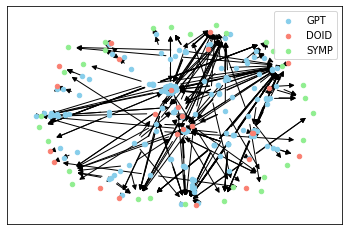

number of nodes:  208
number of edges:  344


In [33]:
# Extract node types
gptid_nodes = []
doid_nodes = []
symp_nodes = []

for node, data in gptid_disease_symp_graph.nodes(data=True):
    if data.get('ntype') == 'GPT':
        gptid_nodes.append(node)        
    elif node.startswith('DOID'):
        doid_nodes.append(node)        
    elif node.startswith('SYMP'):
        symp_nodes.append(node)

# Visualize the graph
pos = nx.spring_layout(gptid_disease_symp_graph, seed=42)
nx.draw_networkx_nodes(gptid_disease_symp_graph, pos, nodelist=gptid_nodes, node_size=20, node_color='skyblue', label='GPT')
nx.draw_networkx_nodes(gptid_disease_symp_graph, pos, nodelist=doid_nodes, node_size=20, node_color='salmon', label='DOID')
nx.draw_networkx_nodes(gptid_disease_symp_graph, pos, nodelist=symp_nodes, node_size=20, node_color='lightgreen', label='SYMP')
nx.draw_networkx_edges(gptid_disease_symp_graph, pos)

plt.legend()
plt.show()

print("number of nodes: ", len(gptid_disease_symp_graph.nodes))
print("number of edges: ", len(gptid_disease_symp_graph.edges))

In [34]:
# Write the graph to a pickle file
output_file = "gpt_disease_symp_graph_"+str(seed)+"_250abs.pickle"
nx.write_gpickle(gptid_disease_symp_graph, output_file)

In [35]:
# toload_file = "gpt_disease_symp_graph_"+str(seed)+"_250abs.pickle"
# # Load the graph from the pickle file
# with open(toload_file, 'rb') as file:
#     loaded_graph = pickle.load(file)

# # Verify that the loaded graph is the same as the original graph
# print(loaded_graph.nodes(data=True))  # Output: [1, 2]
# print(len(loaded_graph.edges()))  # Output: [(1, 2)]